In [1]:
# MIT License

# Copyright (c) [2019] [Jayden Booth]

# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:

# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.

# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
# OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
# SOFTWARE.

# Import Relevant Libraries
import numpy as np
from scipy import special
import tensorflow as tf
from keras.layers import Input, Dense, GaussianNoise, Lambda, concatenate, Reshape
from keras.models import Model
from keras import regularizers
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam,SGD
from keras import backend as K
from keras.losses import categorical_crossentropy
import random as rn
%matplotlib inline

Using TensorFlow backend.


In [2]:
# Set random seed for reproducing results
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(3)

In [3]:
# defining parameters
# define (n,k) here for (n,k) autoencoder
# n = n_channel 
# k = log2(M)  ==> so for (7,4) autoencoder n_channel = 7 and M = 2^4 = 16

# Transmitter Params
M = 16
k = np.log2(M)
k = int(k)
n_channel = 1
R = k/n_channel

# Receiver Params
power_weight_param = 1
antenna_impedance = 50
diode_ideality_factor = 1
diode_thermal_voltage = 0.02585
print ('M:',M,'k:',k,'n:',n_channel)

M: 16 k: 4 n: 1


In [4]:
# Generating data of size N
N = 100000
label = np.random.randint(M,size=N)

In [5]:
# Creating one hot encoded vectors
data = np.zeros((N,M))

for i in np.arange(0,N):
    data[i,label[i]] = 1

In [6]:
# Checking data shape
data = np.array(data)
print(data.shape)

(100000, 16)


In [7]:
# Check data
temp_check = np.random.randint(N,size=10)

for i in temp_check:
    print(label[i],data[i])
    
out_data = [data,np.zeros(N)]

9 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
15 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
5 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
4 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
11 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
6 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
10 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
7 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
8 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
10 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


In [8]:
# Custom Loss Function
# loss = cross entropy of one-hot message plus inverse of power times a constant
# y_pred containts M values for one-hot message and then 1 value corresponding to the recieved power
def power_cross_entropy(y_true,y_pred):
    M_pred = y_pred[:,0:M]
    power = y_pred[:,M]
    M_true = y_true
    e_loss = K.sum(K.categorical_crossentropy(M_true,M_pred))
    p_loss = K.sum(power_weight_param / power)
    num_inputs = K.shape(y_true)[0]
    
    return (e_loss + p_loss) / K.cast(num_inputs,'float32')

# Calculate the recieved power of the signal
# Derivation is shown in "A Learning Approach to Wireless Information and Power Transfer Signal and System Design"
# by Morteza Varsteh, Enrico Piovano, and Bruno Clerckx
# Input is a complex number representing recieved signal
# Output is the recieved power
def recieved_power(x):
    mag_x = K.sqrt(K.sum(K.square(x),axis=1))
    B = np.sqrt(antenna_impedance)/(diode_ideality_factor*diode_thermal_voltage)
    
    return tf.math.bessel_i0(mag_x)
    

In [9]:
# Defined autoencoder

# Transmitter
input_signal = Input(shape=(M,))
encoded = Dense(2*n_channel,activation='relu')(input_signal)
encoded1 = Dense(2*n_channel,activation='linear')(encoded)
encoded2 = BatchNormalization()(encoded1)
encoded3 = Lambda(lambda x:1/np.sqrt(2)*K.l2_normalize(x,axis=-1))(encoded2)

# Channel
EbNo_train = 5.01187 #  coverted 7 db of EbNo
channel = GaussianNoise(np.sqrt(1/(2*R*EbNo_train)))(encoded3)

# Reciever
decoded = Dense(M,activation='relu')(channel)
decoded1 = Dense(M,activation='softmax')(decoded)

# P_del
p_del = Lambda(recieved_power)(channel)
p_del1 = Reshape((1,))(p_del)
output = concatenate([decoded1,p_del1])

# Model
autoencoder = Model(input_signal,output)
adam = Adam(lr=0.01)
sgd = SGD(lr=0.02)
autoencoder.compile(optimizer=adam,loss=power_cross_entropy)

W0801 18:56:29.952365 140576298309440 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0801 18:56:29.954511 140576298309440 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0801 18:56:29.960292 140576298309440 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0801 18:56:30.103024 140576298309440 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0801 18:56:30.149303 

In [10]:
# printing summary of layers and it's trainable parameters 
print (autoencoder.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 16)           0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 2)            34          input_1[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 2)            6           dense_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 2)            8           dense_2[0][0]                    
__________________________________________________________________________________________________
lambda_1 (

In [11]:
# traning auto encoder
autoencoder.fit(data, data,
                epochs=50,
                batch_size=256)

W0801 18:56:30.468563 140576298309440 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/50
100000/100000 [==============================] - 5s 52us/step - loss: 2.0557
Epoch 2/50
100000/100000 [==============================] - 4s 37us/step - loss: 1.8152
Epoch 3/50
100000/100000 [==============================] - 4s 36us/step - loss: 1.8040
Epoch 4/50
100000/100000 [==============================] - 4s 36us/step - loss: 1.7964
Epoch 5/50
100000/100000 [==============================] - 4s 36us/step - loss: 1.7909
Epoch 6/50
100000/100000 [==============================] - 4s 36us/step - loss: 1.7927
Epoch 7/50
100000/100000 [==============================] - 4s 37us/step - loss: 1.7911
Epoch 8/50
100000/100000 [==============================] - 4s 36us/step - loss: 1.7880
Epoch 9/50
100000/100000 [==============================] - 4s 38us/step - loss: 1.7837
Epoch 10/50
100000/100000 [==============================] - 4s 36us/step - loss: 1.7831
Epoch 11/50
100000/100000 [==============================] - 4s 36us/step - loss: 1.7860
Epoch 12/50
100000/100000 [===

In [12]:
# making encoder from full autoencoder
encoder = Model(input_signal, encoded3)

In [13]:
# making decoder from full autoencoder
encoded_input = Input(shape=(2*n_channel,))

deco = autoencoder.layers[-5](encoded_input)
deco = autoencoder.layers[-3](deco)
decoder = Model(encoded_input, deco)

In [14]:
# generating data for checking BER
N = 70000
test_label = np.random.randint(M,size=N)
test_data = []

for i in test_label:
    temp = np.zeros(M)
    temp[i] = 1
    test_data.append(temp)
    
test_data = np.array(test_data)

(16, 1, 2)


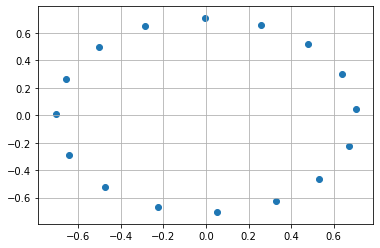

In [15]:
# for plotting learned consteallation diagram

scatter_plot = []
for i in range(0,M):
    temp = np.zeros(M)
    temp[i] = 1
    scatter_plot.append(encoder.predict(np.expand_dims(temp,axis=0)))
scatter_plot = np.array(scatter_plot)
print (scatter_plot.shape)

# ploting constellation diagram
import matplotlib.pyplot as plt
scatter_plot = scatter_plot.reshape(M,2,1)
plt.scatter(scatter_plot[:,0],scatter_plot[:,1])

plt.grid()
plt.show()

In [16]:
# calculating BER
# this is optimized BER function so it can handle large number of N
# previous code has another for loop which was making it slow
EbNodB_range = list(np.arange(0,20+1,2))
ber = [None]*len(EbNodB_range)
for n in range(0,len(EbNodB_range)):
    EbNo=10.0**(EbNodB_range[n]/10.0)
    noise_std = np.sqrt(1/(2*R*EbNo))
    noise_mean = 0
    no_errors = 0
    nn = N
    noise = np.random.randn(nn,2*n_channel)*noise_std
    encoded_signal = encoder.predict(test_data) 
    final_signal = encoded_signal + noise
    pred_final_signal =  decoder.predict(final_signal)
    pred_output = np.argmax(pred_final_signal,axis=1)
    no_errors = (pred_output != test_label)
    no_errors =  no_errors.astype(int).sum()
    ber[n] = no_errors / nn 
    print ('SNR:',EbNodB_range[n],'BER:',ber[n])

SNR: 0 BER: 0.6984714285714285
SNR: 2 BER: 0.6264857142857143
SNR: 4 BER: 0.5430857142857143
SNR: 6 BER: 0.44507142857142856
SNR: 8 BER: 0.3431
SNR: 10 BER: 0.24198571428571428
SNR: 12 BER: 0.14905714285714286
SNR: 14 BER: 0.0814
SNR: 16 BER: 0.03822857142857143
SNR: 18 BER: 0.013971428571428572
SNR: 20 BER: 0.004914285714285714


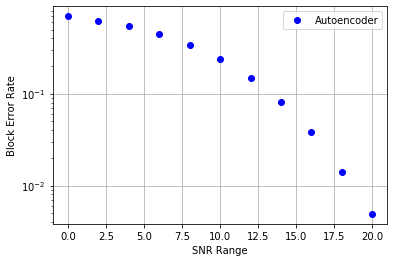

In [17]:
# ploting ber curve
import matplotlib.pyplot as plt
from scipy import interpolate
plt.plot(EbNodB_range, ber, 'bo',label='Autoencoder')
plt.yscale('log')
plt.xlabel('SNR Range')
plt.ylabel('Block Error Rate')
plt.grid()
plt.legend(loc='upper right',ncol = 1)
plt.show()